<a href="https://colab.research.google.com/github/bhaspeacebro/data-collection-and-preprocessing/blob/main/Resturant%20_rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install any missing libraries (usually not needed for common ones in Colab)
# !pip install pandas scikit-learn numpy matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [5]:
# If your file is uploaded directly to Colab session storage:
df = pd.read_csv('/Dataset .csv') # Replace with your actual filename



In [6]:
print(df.head())
print(df.info())
print(df.describe())

   Restaurant ID         Restaurant Name  Country Code              City  \
0        6317637        Le Petit Souffle           162       Makati City   
1        6304287        Izakaya Kikufuji           162       Makati City   
2        6300002  Heat - Edsa Shangri-La           162  Mandaluyong City   
3        6318506                    Ooma           162  Mandaluyong City   
4        6314302             Sambo Kojin           162  Mandaluyong City   

                                             Address  \
0  Third Floor, Century City Mall, Kalayaan Avenu...   
1  Little Tokyo, 2277 Chino Roces Avenue, Legaspi...   
2  Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...   
3  Third Floor, Mega Fashion Hall, SM Megamall, O...   
4  Third Floor, Mega Atrium, SM Megamall, Ortigas...   

                                     Locality  \
0   Century City Mall, Poblacion, Makati City   
1  Little Tokyo, Legaspi Village, Makati City   
2  Edsa Shangri-La, Ortigas, Mandaluyong City   
3      SM 

In [7]:
print("Missing values before handling:")
print(df.isnull().sum())

# Example: Impute numerical columns with median and categorical with most frequent
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Remove 'Aggregate rating' from numerical_cols if it's there, as it's the target
if 'Aggregate rating' in numerical_cols:
    numerical_cols.remove('Aggregate rating')

# Impute numerical columns with the median
for col in numerical_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

# Impute categorical columns with the mode
for col in categorical_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing values after handling:")
print(df.isnull().sum())

Missing values before handling:
Restaurant ID           0
Restaurant Name         0
Country Code            0
City                    0
Address                 0
Locality                0
Locality Verbose        0
Longitude               0
Latitude                0
Cuisines                9
Average Cost for two    0
Currency                0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Switch to order menu    0
Price range             0
Aggregate rating        0
Rating color            0
Rating text             0
Votes                   0
dtype: int64

Missing values after handling:
Restaurant ID           0
Restaurant Name         0
Country Code            0
City                    0
Address                 0
Locality                0
Locality Verbose        0
Longitude               0
Latitude                0
Cuisines                0
Average Cost for two    0
Currency                0
Has Table booking       0
Has Online delivery     0
Is delivering

/tmp/ipython-input-7-1763034299.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [8]:
# Drop columns that are identifier or direct labels of the target (e.g., Restaurant ID, Rating color/text)
# Adjust this list based on your specific features
columns_to_drop = ['Restaurant ID', 'Restaurant Name', 'Address', 'Locality', 'Locality Verbose', 'Rating color', 'Rating text']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

# Identify remaining categorical columns for encoding
categorical_features = df.select_dtypes(include='object').columns.tolist()
print(f"\nCategorical features to encode: {categorical_features}")

# Apply One-Hot Encoding
df = pd.get_dummies(df, columns=categorical_features, drop_first=True) # drop_first avoids multicollinearity


Categorical features to encode: ['City', 'Cuisines', 'Currency', 'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu']


In [9]:
# Convert 'Price range' to numeric if it's an object type after initial loading
if 'Price range' in df.columns and df['Price range'].dtype == 'object':
    df['Price range'] = pd.to_numeric(df['Price range'], errors='coerce')
    # Handle any new NaNs introduced by coercion if needed
    df['Price range'].fillna(df['Price range'].median(), inplace=True)

In [10]:
# Define features (X) and target (y)
X = df.drop('Aggregate rating', axis=1)
y = df['Aggregate rating']

# Ensure all features are numeric; drop any remaining non-numeric columns if necessary
X = X.select_dtypes(include=np.number)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (7640, 6)
y_train shape: (7640,)
X_test shape: (1911, 6)
y_test shape: (1911,)


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression # Another option
from sklearn.tree import DecisionTreeRegressor # Another option

# Choose a model - RandomForestRegressor is a good starting point for robustness
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores

# Train the model
print("\nTraining the model...")
model.fit(X_train, y_train)
print("Model training complete.")


Training the model...
Model training complete.


In [12]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Model Evaluation Metrics:
Mean Squared Error (MSE): 0.0969
Root Mean Squared Error (RMSE): 0.3113
R-squared (R2 Score): 0.9574
Mean Absolute Error (MAE): 0.2044



Most Influential Features (Top 15):
Votes                   0.950087
Longitude               0.019960
Latitude                0.017095
Average Cost for two    0.008216
Country Code            0.003540
Price range             0.001103
dtype: float64


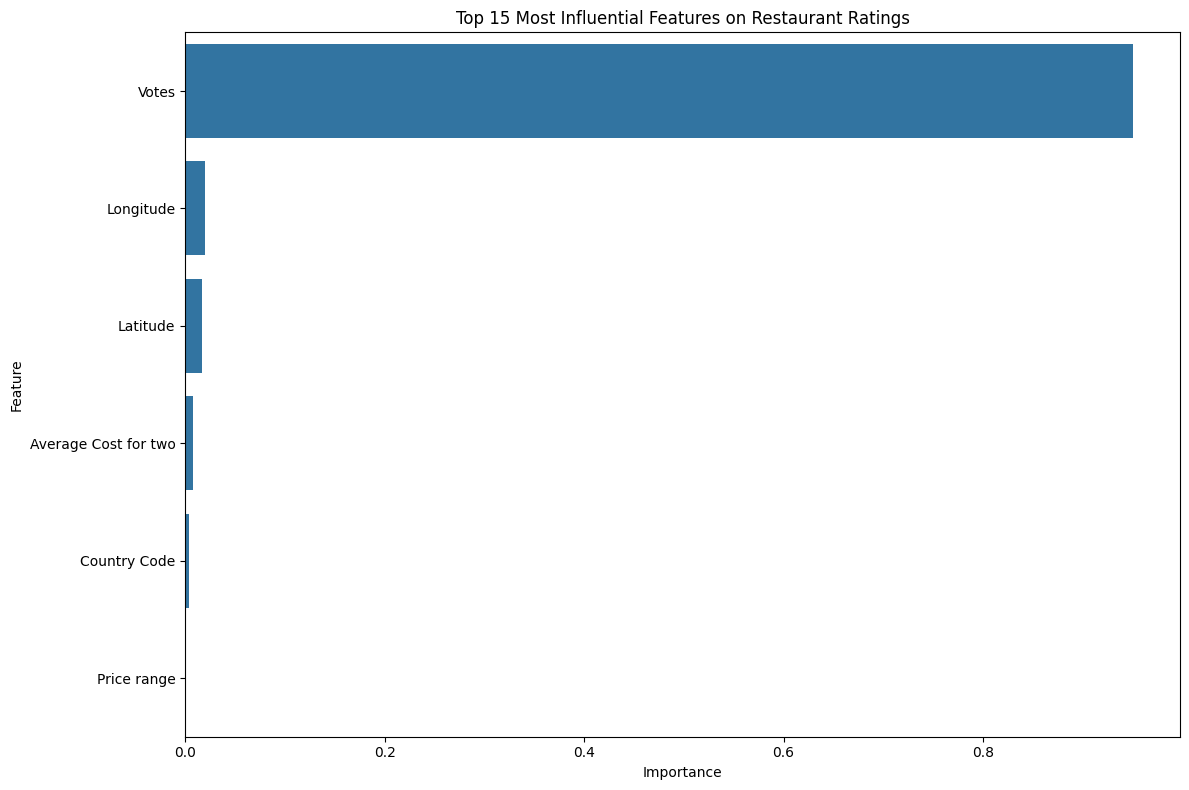

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance (for tree-based models)
if hasattr(model, 'feature_importances_'):
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    sorted_feature_importances = feature_importances.sort_values(ascending=False)

    print("\nMost Influential Features (Top 15):")
    print(sorted_feature_importances.head(15))

    # Visualize feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x=sorted_feature_importances.head(15).values, y=sorted_feature_importances.head(15).index)
    plt.title('Top 15 Most Influential Features on Restaurant Ratings')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("\nFeature importance not directly available for this model type. Consider using SHAP or LIME for interpretation.")
    # If using LinearRegression, you'd examine model.coef_